# Transfer Learning techniques in Pneumonia Medical Diagnosis
## By Anosh.S

- Deep image learning image classification models
- Leveraging pre-existing models 
- Using transfer learning and retraining the later layers (prediction layers) to the particular use case i.e. Pneumonia Medical Diagnosis, applying the keras flow from directory implementation

## Importing the Data to Colab

In [1]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Saving kaggle.json to kaggle.json
 99% 2.27G/2.29G [00:26<00:00, 94.7MB/s]
100% 2.29G/2.29G [00:26<00:00, 93.7MB/s]


In [3]:
import os

from numpy.random import seed
from tensorflow import set_random_seed

if not os.path.exists('data'):
  !unzip chest-xray-pneumonia.zip -d data

os.remove('chest-xray-pneumonia.zip')

Archive:  chest-xray-pneumonia.zip
  inflating: data/chest_xray/__MACOSX/._chest_xray  
  inflating: data/chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: data/chest_xray/__MACOSX/chest_xray/._test  
  inflating: data/chest_xray/__MACOSX/chest_xray/._train  
  inflating: data/chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: data/chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: data/chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: data/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: data/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: data/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: data/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: data/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0007-0001.jpeg  
  inflating: data/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0009-0001.jpeg  
  inflating: data/chest_xray/__MA

## Helper Functions

In [0]:
def search_dir(type = 'normal', num = 6):
  # Helper function to scan contents of a directory
  counter = 0

  for file in os.listdir(train_dir + type.upper() + '/'):
    if counter == num:
      break
    
    if file.endswith('.jpeg'):
      print(file)
    
    counter += 1

# Plots the images for a particular directory
def plot_images(type = 'normal', num = 6):
  counter = 0
  fig = plt.figure(figsize = (10, 8))

  for file in os.listdir(train_dir + type.upper()):

    if file.endswith('.jpeg'):
      if counter == num:
        break

      img = mpimg.imread(train_dir + type.upper() + '/' + file)
      plt.subplot(231 + counter)
      plt.title(file.split('.')[0])
      imgplot = plt.imshow(img)

      counter += 1

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Exploring and Understanding the Data

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Point to the relevant directories
train_dir = 'data/chest_xray/train/'
val_dir = 'data/chest_xray/test/' #directories for training
test_dir = 'data/chest_xray/val/' #directory for final modeling

person1259_virus_2139.jpeg
person1336_virus_2306.jpeg
person1430_bacteria_3695.jpeg
person437_virus_888.jpeg
person1544_bacteria_4035.jpeg
person1310_bacteria_3304.jpeg
person506_bacteria_2136.jpeg
person277_bacteria_1306.jpeg
person1235_virus_2095.jpeg
person351_bacteria_1617.jpeg
NORMAL2-IM-1138-0001.jpeg
NORMAL2-IM-0904-0001.jpeg
NORMAL2-IM-1257-0001.jpeg
IM-0764-0001.jpeg
IM-0487-0001.jpeg
NORMAL2-IM-1360-0001.jpeg
IM-0392-0001.jpeg
IM-0279-0001.jpeg
NORMAL2-IM-1142-0001-0001.jpeg
IM-0580-0001.jpeg


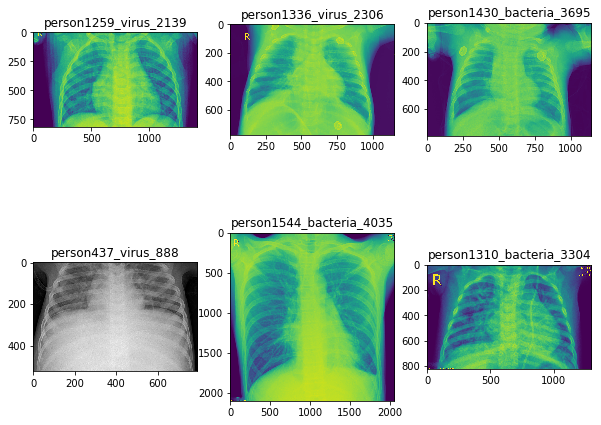

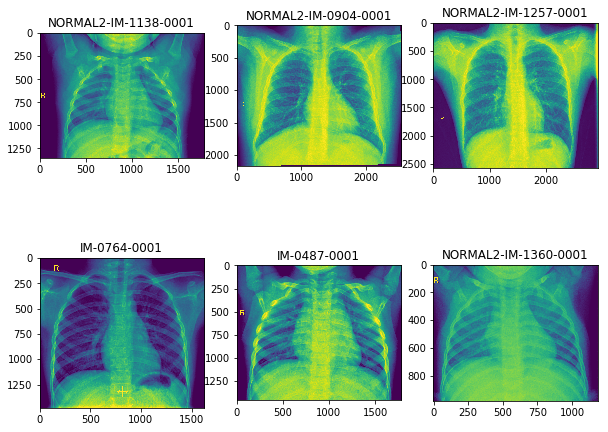

In [11]:
search_dir(type = 'pneumonia', num = 10)
search_dir(type = 'normal', num = 10)
plot_images(type = 'pneumonia', num = 6)
plot_images(type = 'normal', num = 6)

## Retraining and Modeling



### Pre-training without transfer learning
Choosing from the images imported from the chest x_ray dataset we are requesting a prediction using the image classification kearas api.  

In [13]:
import numpy as np 
from keras.applications.inception_v3 import InceptionV3 #image classification model
from keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.python.keras.preprocessing import image

#Utilising TensorFlow backend - keras api

pre_model = InceptionV3(weights = 'imagenet') # initiating the weights

img = image.load_img('/content/data/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg', target_size = (299, 299))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

y = pre_model.predict(x)
for index, res in enumerate(decode_predictions(y)[0]):
  print('{}. {}: {:.3f}%'.format(index + 1, res[1], 100 * res[2]))




40960/35363 [==================================] - 0s 0us/step
1. water_bottle: 73.426%
2. isopod: 16.616%
3. scorpion: 1.624%
4. trilobite: 0.468%
5. water_jug: 0.425%


### Preparing the Data

In [16]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 163

# Create training data generator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_directory(
    train_dir, # directory that contains training data
    target_size = (150, 150), # what size image we want
    batch_size = batch_size, # how many files to read in at a time
    class_mode = 'categorical'
)

Found 5216 images belonging to 2 classes.


In [23]:
# Create validation data generator

val_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (150, 150),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 624 images belonging to 2 classes.


In [17]:
# Create validation test generator

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 1,
    class_mode = 'categorical',
    shuffle = False
)

Found 16 images belonging to 2 classes.


### Training the Model

In [0]:
import keras

In [0]:
base_model = InceptionV3(weights = 'imagenet', include_top = False)

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation = 'relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation = 'softmax')(x)

for layer in base_model.layers:
  layer.trainable = False # Freeze the layers not to train

# Creating our final model
final_model = keras.models.Model(inputs = base_model.inputs, outputs = predictions)

In [32]:
# The loss, method of optimisation and metrics
final_model.compile(loss = 'categorical_crossentropy',
                    optimizer = 'adam',
                    metrics = ['accuracy'])

In [33]:
# Training the model; increasing epochs increases the number of iterations the model is trained raising potential accuracy and effectiveness
fit_history = final_model.fit_generator(
    train_generator, # train data generator
    steps_per_epoch = len(train_generator),
    epochs = 5,
    validation_data = val_generator, # validation data generator
    validation_steps = len(val_generator)
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
32/32 [==============================] - 82s 3s/step - loss: 0.7130 - acc: 0.8131 - val_loss: 1.4357 - val_acc: 0.7196
Epoch 2/5
32/32 [==============================] - 69s 2s/step - loss: 0.2405 - acc: 0.9064 - val_loss: 3.4345 - val_acc: 0.4824
Epoch 3/5
32/32 [==============================] - 72s 2s/step - loss: 0.2310 - acc: 0.9116 - val_loss: 1.0523 - val_acc: 0.7276
Epoch 4/5
32/32 [==============================] - 72s 2s/step - loss: 0.2174 - acc: 0.9137 - val_loss: 0.9809 - val_acc: 0.7436
Epoch 5/5
32/32 [==============================] - 72s 2s/step - loss: 0.2160 - acc: 0.9118 - val_loss: 2.6717 - val_acc: 0.6731


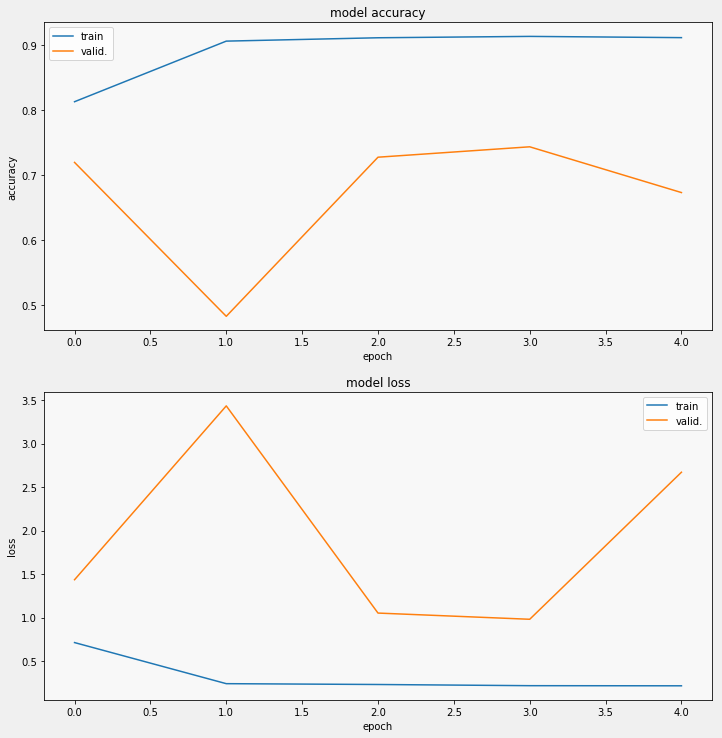

In [42]:
# Visualising accuracy and loss accross different epochs
display_training_curves(fit_history.history['acc'], fit_history.history['val_acc'], 'accuracy', 211)
display_training_curves(fit_history.history['loss'], fit_history.history['val_loss'], 'loss', 212)

In [43]:
# Running the model on the test generators  
result = final_model.evaluate_generator(test_generator, steps = len(test_generator))
print('Loss:', result[0])
print('Accuracy:', result[1])

Loss: 2.959681510925293
Accuracy: 0.5625


In [44]:
# Classes based on alphabetical order for classes so using this to double check class assignment by indicies
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [53]:
# Generate all predictions
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = final_model.predict_generator(test_generator,steps = nb_samples).argmax(axis=-1)

predict

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1])

In [46]:
# Generate true labels
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

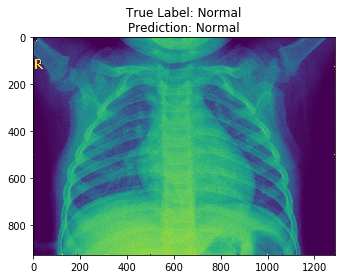

In [51]:
#@title Enter Filepath Here:
filename = "/content/data/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg" #@param {type:"string"}

img = image.load_img(filename, 
                     target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = final_model.predict(x)

predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
actual="Normal" if "NORMAL" in filename else "Pneumonia" 

img=mpimg.imread(filename)
title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
plt.title(title_text)
imgplot=plt.imshow(img)